<a href="https://www.kaggle.com/code/vainero/stock-price-prediction-lstm?scriptVersionId=115928580" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<center><img src="https://github.com/vainero/Files/blob/main/Stock.gif?raw=true"></center>
<h1 style="color:#d16969; font-style:italic; font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px;"> <center>Thanks for visiting my notebook!</center> </h1>

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Content</p>

> * In this notebook, we will focus on the **Long Short-Term Memory (LSTM)** layer model in Keras to predict if the stock will go up or down.
>
> * Historical daliy **NFLX** stock price was collected from Yahoo Finance.

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Import Libraries</p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Loading Data</p>

In [3]:
data = pd.read_csv('../input/netflix-stock-price-data-set-20022022/NFLX.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


|<font color='#145f19'>Price</font> | <font color='#145f19'>Description</font> 
|:--- | :---|
|<font color='darkred'>Open</font>| The price of the stock at the beginning of the trading day|
|<font color='darkred'>High</font>| The highest price of the stock on the trading day|
|<font color='darkred'>Low</font> | The lowest price of the stock on the trading day|
|<font color='darkred'>Close</font>| The last price of the stock before the trading day ends|


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5044 non-null   object 
 1   Open       5044 non-null   float64
 2   High       5044 non-null   float64
 3   Low        5044 non-null   float64
 4   Close      5044 non-null   float64
 5   Adj Close  5044 non-null   float64
 6   Volume     5044 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 276.0+ KB


In [5]:
# The data type of the "Date" column is int64, we need to convert it into date-time.
data["Date"] = pd.to_datetime(data["Date"])
print (data.dtypes)

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


In [6]:
# The data type of the "Date" column is int64, we need to convert it into date-time.
data["Year"] = data["Date"].apply(lambda x : str(x)[:4])
data["Month"] = data["Date"].apply(lambda x : str(x)[5:7])
data["Day"] = data["Date"].apply(lambda x : str(x)[8:10])

data['ds'] = pd.DatetimeIndex(data["Year"] +"-"+ data["Month"] +"-"+ data["Day"])
data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,ds
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,2002,05,23,2002-05-23
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,2002,05,24,2002-05-24
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,2002,05,28,2002-05-28


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Feature Extraction</p>

In [7]:
# Show the number of trading days
print("Total number of traiding days: ",data.shape[0])
print("Total number of fields: ",data.shape[1])

Total number of traiding days:  5044
Total number of fields:  11


In [8]:
# Check the Null and NA values
print("Null values:", data.isnull().values.sum())
print("NA values:", data.isna().values.any())

Null values: 0
NA values: False


> * We will select from the dataset the **Open** column represents the starting price of the stock for a particular day. 

In [9]:
# Create a new dataframe with only the Open column and convert it into a NumPy array
data = data['Open'].values

# Reshape the data
data = data.reshape(-1, 1) 

In [10]:
# Split the data into training and testing sets
dataset_train = np.array(data[:int(data.shape[0]*0.8)])
dataset_test = np.array(data[int(data.shape[0]*0.8):])

> * To produce the best-optimized results, we are required to scale the data. 
>
> * For this task, we are leveraging scikit-learn library’s **MinMaxScaler()** for converting the input values between 0 to 1.

In [11]:
# Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))

dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

> * We will create the helper function with 50 timesteps. In other words, for the features(x) we'll append the last 50 prices, and for the label(y) we'll append the next price.
>
> * After that we will convert it into a NumPy array.

In [12]:
# Create the function that will help us to create the datasets
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0]) 
        y.append(df[i, 0]) 
    x = np.array(x) 
    y = np.array(y)
    return x,y

In [13]:
# Create the training and testing data by calling our function for each one
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [14]:
# Reshape the data to make it a 3D array in order to use it in LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Building Model</p>
> * For the LSTM layer, we add **96 units** that represent the dimensionality of the output space. 
>
> * The **return_sequences parameter** is set to **True** for returning the last output in output.
>
> * For the Dropout layers, we specify the percentage of layers is **20%** that should be dropped. 
>
> * The next step is to add the Dense layer. 

In [16]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1)) 

In [17]:
# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 96)            37632     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 96)               

In [18]:
# Reshape the feature for the LSTM layer 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # for expecting 3 dimentions, not 2
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

> * We will compile the model with the help of **adam** optimizer.
>
> * The error is computed using **mean_squared_error**.

In [19]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam') 

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Training Model</p>
> * With our model and data constructed, we can now train the model.

In [20]:
# Define modifiable training hyperparameters
epochs = 40
batch_size = 64 

# Save the model and start the training
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
model.save('stock_prediction')

2023-01-09 18:21:53.168274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2023-01-09 18:21:58.595618: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


63/63 [==============================] - 8s 13ms/step - loss: 0.0032
Epoch 2/40
63/63 [==============================] - 1s 12ms/step - loss: 7.2922e-04
Epoch 3/40
63/63 [==============================] - 1s 13ms/step - loss: 7.5686e-04
Epoch 4/40
63/63 [==============================] - 1s 14ms/step - loss: 7.1893e-04
Epoch 5/40
63/63 [==============================] - 1s 15ms/step - loss: 6.3664e-04
Epoch 6/40
63/63 [==============================] - 1s 13ms/step - loss: 5.2905e-04
Epoch 7/40
63/63 [==============================] - 1s 13ms/step - loss: 6.9716e-04
Epoch 8/40
63/63 [==============================] - 1s 13ms/step - loss: 9.1116e-04
Epoch 9/40
63/63 [==============================] - 1s 12ms/step - loss: 5.1440e-04
Epoch 10/40
63/63 [==============================] - 1s 12ms/step - loss: 4.1903e-04
Epoch 11/40
63/63 [==============================] - 1s 12ms/step - loss: 5.6070e-04
Epoch 12/40
63/63 [==============================] - 1s 12ms/step - loss: 4.3002e-04
Epoc

2023-01-09 18:22:45.208953: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [21]:
# Load the model
model = load_model('stock_prediction')

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Prediction Model</p>

In [22]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)) 

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#145f19; font-size:100%; text-align:center;padding: 0px; border-bottom: 3px solid #145f19">Plotting Results</p>

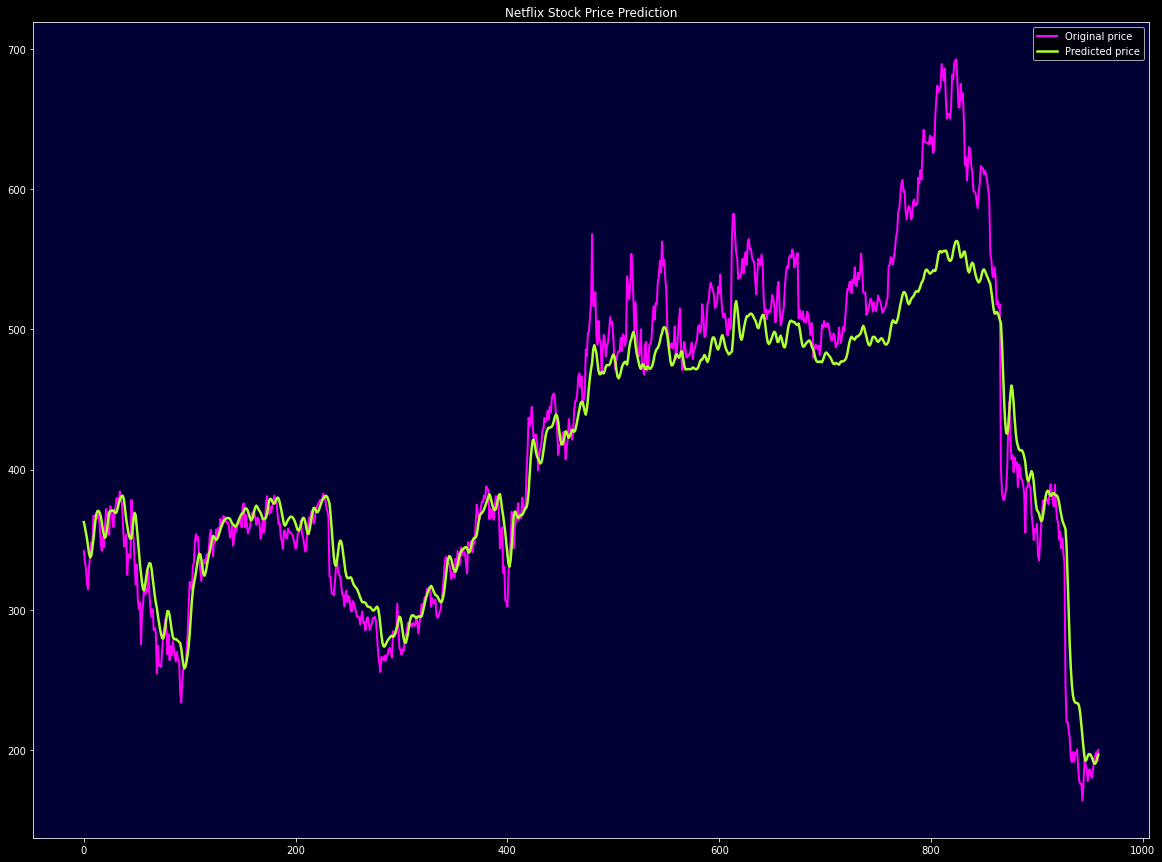

In [23]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20,15))
ax.set_facecolor('#000035')
ax.plot(y_test_scaled, color='fuchsia', linewidth=2, label='Original price')
plt.plot(predictions, color='greenyellow', linewidth=2.5, label='Predicted price')
plt.title('Netflix Stock Price Prediction')
plt.legend(); 

<h3 style="color:#d16969; font-style:italic; font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px;"> <center>Thanks for visiting my notebook!</center> </h3>

<br><center><img src='https://media.giphy.com/media/hpXdHPfFI5wTABdDx9/giphy.gif' 
     height=30px width=160px /></center></br>     
     
<h1 style="color:#145f19; font-style:italic; font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px;"> <center>👍 If you find this notebook useful, please support with an upvote 👍</center> </h1>
